In [14]:
import sys
sys.path.append('./')
sys.path.append('/home/feldheimlab/Documents/pySEAS/')

# key python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler

#new name?
import wholeBrainClassify as wbc

# plt.style.use('publication')
dataset_path = '/media/feldheimlab/DF Transfer/misc - IS THIS YOURS/p21_20m/'
plt.rcParams['font.size'] = 8

save = True
save_dir = '/home/feldheimlab/Desktop/figures/'

In [16]:
path='./data/'
classMetricsPath = path + 'training_dataset.tsv'

domain_vars =['spatial_min', 'spatial_max', 
              'region_minaxis', 'threshold_area', 'region_extent', 'threshold_perc', 'region_majaxis', 'region_majmin_ratio', 
              'temporal_min', 
              'freq_rangesz'             ]

try:
    main_data = pd.read_csv(classMetricsPath, sep = '\t', index_col='exp_ic')
    print('Importing dataframe\n------------------------------------')
    #renaming the columns
    neural_dict = {}
    
    for col in main_data.columns:
        if "." in col:
            new_col = col.replace(".", "_")
            neural_dict[col] = new_col

    main_data = main_data.rename(columns=neural_dict)
    print(main_data.head())
except Exception as e:
    main_data = pd.DataFrame()
    print('Error importing dataFrame')
    print('\t ERROR : ', e)
    assert not main_data.empty, 'Check path to metrics dataframe'

    
droplist = ['anml','artifact','signal','age', 'length', 'spatial_COMdom_x', 'spatial_COMdom_y', 'mass_perc', 'mass_region','mass_total']
try:
    main_data = main_data.fillna(value=0).copy()
    data = main_data.drop(droplist, axis=1).copy()
except Exception as e:
    data = _main_data.fillna(value=0).copy()
    print(e)
    
scaler = StandardScaler()
scaler.fit(data.values)
data[:] = scaler.transform(data.values)
# main_data -= main_data.min()
# main_data /= main_data.max()
# main_data.to_csv(classMetricsPath, sep = '\t')

# domain = main_data.loc[main_data['threshold.area'] != 0].copy()
# nodomain = main_data.loc[main_data['threshold.area'] == 0].copy()
print(data.isnull().sum())
print(main_data['signal'].isnull().sum())

Importing dataframe
------------------------------------
                   age  freq_avgsnr  freq_integrate  freq_maxsnr  \
exp_ic                                                             
190408_03-04-0000   22     1.193897        0.006304     1.327806   
190408_03-04-0001   22     1.422100        0.120683     1.620314   
190408_03-04-0002   22     1.296523        0.107689     1.513039   
190408_03-04-0003   22     1.172093        0.179745     1.306229   
190408_03-04-0004   22     2.093038        0.589769     3.606708   

                   freq_maxsnr_freq  freq_range_high  freq_range_low  \
exp_ic                                                                 
190408_03-04-0000          4.204482         4.585020        2.973018   
190408_03-04-0001          4.585020         0.005325        0.004883   
190408_03-04-0002          4.585020         0.005325        0.004883   
190408_03-04-0003          2.973018         0.963882        0.371627   
190408_03-04-0004          3.24209

In [17]:
score = []
precision = []
recall = []
signal = []
artifact = []

truep =[]
truen =[]
falsep = []
falsen = []

clas = main_data.loc[:,'artifact'].copy()
clas = np.abs(clas - 1)

n_iter = 1000

for i in range(n_iter): # 1000 iterations of models
    Xlen = len(main_data)
    
    X_train, X_test, y_train, y_test = wbc.splitData(data.loc[:,domain_vars].copy(),clas)
    rnd_clf = RandomForestClassifier(n_estimators = 40, max_features = 2)

    rnd_clf.fit(X_train, y_train)
    y_pred = rnd_clf.predict(X_test)
    y_pred_2 = rnd_clf.predict(X_train)
    
    rnd_score = rnd_clf.score(X_test, y_test)
    rnd_precision =  precision_score(y_test, y_pred)
    rnd_recall = recall_score(y_test, y_pred)
    rnd_signal = (np.sum(((y_pred==1) & (y_test==1))))/(np.sum((y_test==1)))
    rnd_artifact = (np.sum(((y_pred==0) & (y_test==0))))/(np.sum(y_test==0))

    truep.append(np.sum(y_pred[y_test==1]==y_test[y_test==1]) + np.sum(y_pred_2[y_train==1]==y_train[y_train==1]))
    truen.append(np.sum(y_pred[y_test==0]==y_test[y_test==0]) + np.sum(y_pred_2[y_train==0]==y_train[y_train==0]))
    falsen.append(np.sum(y_pred[y_test==1]!=y_test[y_test==1]) + np.sum(y_pred_2[y_train==1]!=y_train[y_train==1]))
    falsep.append(np.sum(y_pred[y_test==0]!=y_test[y_test==0]) + np.sum(y_pred_2[y_train==0]!=y_train[y_train==0]))

    score.append(rnd_score)
    precision.append(rnd_precision)
    recall.append(rnd_recall)


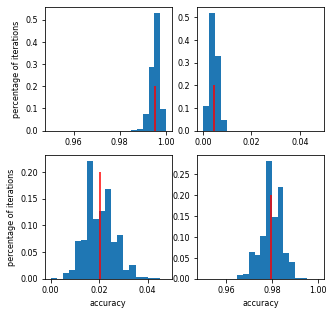


Accuracy of neural: 
True positive (neural):  0.9952039319584934
False positive (i.e. artifact but classified neural):  0.004796068041506483

Accuracy of artifact: 
True negative (artifact):  0.9796965527797442
False negative (i.e. neural but classified artifact):  0.020303447220255788


In [50]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize = (5, 5))
nbin = 15

falsebins = np.arange(0, .05, .05/20)
truebins = np.arange(0.95, 1., .05/20)

average_tp = np.mean(truep)+np.mean(falsep)
axs[0][0].hist(truep/average_tp,
               bins = truebins, weights=np.ones(n_iter)/n_iter)
axs[0][0].vlines(np.mean(truep)/average_tp, 
                 ymin= 0, ymax = 0.2, color='red')
axs[0][0].set_ylabel('percentage of iterations')

average_tn = np.mean(truen)+np.mean(falsen)
axs[1][1].hist(truen/average_tn, 
               bins = truebins, weights=np.ones(n_iter)/n_iter)
axs[1][1].vlines(np.mean(truen)/average_tn, 
                 ymin= 0, ymax = .2, color='red')
axs[1][1].set_xlabel('accuracy')

axs[0][1].hist(falsep/average_tp, 
               bins = falsebins, weights=np.ones(n_iter)/n_iter) #top right
axs[0][1].vlines(np.mean(falsep)/(np.mean(truep)+np.mean(falsep)), 
                 ymin= 0, ymax = .2, color='red')

axs[1][0].hist(falsen/average_tn, 
               bins = falsebins, weights=np.ones(n_iter)/n_iter) #bottom left
axs[1][0].vlines(np.mean(falsen)/average_tn, 
                 ymin= 0, ymax = .2, color='red')
axs[1][0].set_xlabel('accuracy')
axs[1][0].set_ylabel('percentage of iterations')

plt.show()

print('\nAccuracy of neural: ')
print('True positive (neural): ', np.mean(truep)/average_tp)
print('False positive (i.e. artifact but classified neural): ', np.mean(falsep)/average_tp)

print('\nAccuracy of artifact: ')
print('True negative (artifact): ', np.mean(truen)/average_tn)
print('False negative (i.e. neural but classified artifact): ', np.mean(falsen)/average_tn)

In [52]:
classMetricsPath = path + 'novel_dataset.tsv'

try:
    novel_data = pd.read_csv(classMetricsPath, sep = '\t', index_col='exp_ic')
    print('Importing dataframe\n------------------------------------')
    #renaming the columns
    neural_dict = {}
    
    for col in novel_data.columns:
        if "." in col:
            new_col = col.replace(".", "_")
            neural_dict[col] = new_col

    novel_data = novel_data.rename(columns=neural_dict)
    print(novel_data.head())
except Exception as e:
    novel_data = pd.DataFrame()
    print('Error importing dataFrame')
    print('\t ERROR : ', e)
    assert not novel_data.empty, 'Check path to metrics dataframe'

    
droplist = ['anml','artifact','signal','age', 'length', 'spatial_COMdom_x', 'spatial_COMdom_y', 'mass_perc', 'mass_region','mass_total']
try:
    novel_data = novel_data.fillna(value=0).copy()
    test_data = novel_data.drop(droplist, axis=1).copy()
except Exception as e:
    print(e)

scaler = StandardScaler()
scaler.fit(test_data.values)
test_data[:] = scaler.transform(test_data.values)

print(test_data.head())

print(test_data.isnull().sum())
print(novel_data['signal'].isnull().sum())

Importing dataframe
------------------------------------
                   age  freq_avgsnr  freq_integrate  freq_maxsnr  \
exp_ic                                                             
190408_07-08-0000   22          NaN             NaN          NaN   
190408_07-08-0001   22     1.061946        0.028321     1.103959   
190408_07-08-0002   22     1.080982        0.002786     1.124209   
190408_07-08-0003   22     1.037830        0.006557     1.037830   
190408_07-08-0004   22     1.071967        0.031053     1.107243   

                   freq_maxsnr_freq  freq_range_high  freq_range_low  \
exp_ic                                                                 
190408_07-08-0000               NaN              NaN             NaN   
190408_07-08-0001          4.585020         0.008955        0.007530   
190408_07-08-0002          3.855527         3.242099        1.767767   
190408_07-08-0003          5.000000         0.004883        0.004883   
190408_07-08-0004          2.72626

In [53]:
X_train = main_data.loc[:,domain_vars].fillna(0).copy()
scaler.fit(X_train.values)
X_train[:] = scaler.transform(X_train.values)
y_train = main_data.loc[:,'artifact'].copy()
y_train = np.abs(y_train - 1)


classConfidence = pd.DataFrame(index=main_data.index)


print(np.nanmean(classConfidence.values, axis = 1))
print(classConfidence.std())


[nan nan nan ... nan nan nan]
Series([], dtype: float64)


/tmp/ipykernel_414871/1856339481.py:11: RuntimeWarning: Mean of empty slice
  print(np.nanmean(classConfidence.values, axis = 1))


In [54]:

iterations = 1000
nanimals = np.unique(novel_data['anml'])

novel_results = novel_data[['anml','artifact']].copy()
y_test = novel_data['artifact'].copy()
novel_results['neural'] = np.abs(y_test - 1)
novel_results['count'] = 0
novel_true_pos = np.zeros((iterations, len(nanimals)))
novel_true_neg = np.zeros((iterations, len(nanimals)))
novel_false_pos = np.zeros((iterations, len(nanimals)))
novel_false_neg = np.zeros((iterations, len(nanimals)))
explist = []

prec = np.zeros((iterations, len(nanimals)))
reca = np.zeros((iterations, len(nanimals)))
accu = np.zeros((iterations, len(nanimals)))

for j in range(iterations):
    rnd_clf = RandomForestClassifier(n_estimators = 40, max_features = 2)
    rnd_clf.fit(X_train, y_train)
    
    classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
    
    for i, a in enumerate(nanimals):

        subset_test = novel_data.loc[novel_data['anml']==a, domain_vars].copy()

#         scaler.fit(subset_test.values)
        subset_test[:] = scaler.transform(subset_test.values)         
        y_test = novel_data.loc[novel_data['anml']==a, 'artifact'].copy()
        y_test = np.abs(y_test - 1)
        
        if j == 0:
            explist.append(subset_test.index[0][:12])

        y_pred = rnd_clf.predict(subset_test)
    #     novel_data.loc[novel_data['anml']==a,'signal_m'] = y_pred

        accu[j,i] = rnd_clf.score(subset_test, y_test)
        prec[j,i] = precision_score(y_test, y_pred)
        reca[j,i] = recall_score(y_test, y_pred)

        novel_true_pos[j,i]= np.sum(y_pred[y_test==1]==y_test[y_test==1])
        novel_true_neg[j,i]= np.sum(y_pred[y_test==0]==y_test[y_test==0])
        novel_false_neg[j,i]= np.sum(y_pred[y_test==1]!=y_test[y_test==1])
        novel_false_pos[j,i]= np.sum(y_pred[y_test==0]!=y_test[y_test==0])
        novel_results.loc[subset_test.index, 'count'] += y_pred
    #     for index in subset_test[(y_pred==1) & (y_test==0)].index.tolist():
    #         print(index)
    #         print(rnd_clf.predict_proba(subset_test.values)[:,1][int(index[-4:])])
    #     print(subset_test[(y_pred==0) & (y_test==1)].index.tolist())

# novel_data.to_csv( '/media/usb/novel_dataset_ml.tsv', sep = '\t')
# print(novel_true_pos)
# print(novel_true_neg)
# print(novel_false_pos)
# print(novel_false_neg)
print(explist)
novel_results['percent'] = novel_results['count']/iterations
print(novel_results.head())


/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]
/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

['190408_07-08', '190423_03-04', '190508_03-04', '190508_07-08', '200110_01-02']
                   anml  artifact  neural  count  percent
exp_ic                                                   
190408_07-08-0000     1         1       0      5    0.005
190408_07-08-0001     1         1       0      0    0.000
190408_07-08-0002     1         1       0      2    0.002
190408_07-08-0003     1         1       0    814    0.814
190408_07-08-0004     1         1       0      4    0.004


/tmp/ipykernel_414871/354051922.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  classConfidence.loc[X_train.index, j] = rnd_clf.predict_proba(X_train)[:,1]


In [55]:
classConfidencePath = './data/20min_P21_confidence.tsv'
classConfidence.to_csv(classConfidencePath, sep = '\t')



15000
5000


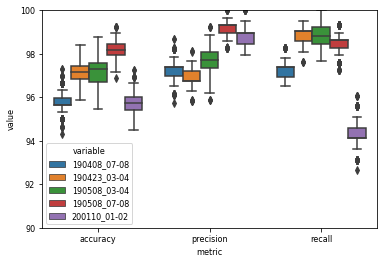

In [58]:
# def precisionfxn(true_pos, false_pos):
#     return true_pos / (true_pos + false_pos)

# def recallfxn(true_pos, false_neg):
#     return true_pos / (true_pos + false_neg)

# def accuracyfxn(true_pos, false_pos, true_neg, false_neg):
#     return (true_pos + true_neg) / (true_pos + true_neg + false_neg + false_pos)

# prec = np.zeros((iterations, len(nanimals)))
# reca = np.zeros((iterations, len(nanimals)))
# accu = np.zeros((iterations, len(nanimals)))
# for j in range(iterations):
#     for i, exp in enumerate(explist):
#         prec[j,i] = precisionfxn(novel_true_pos[j,i], novel_false_pos[j,i])
#         reca[j,i] = recallfxn(novel_true_pos[j,i], novel_false_neg[j,i])
#         accu[j,i] = accuracyfxn(novel_true_pos[j,i], novel_false_pos[j,i], novel_true_neg[j,i], novel_false_neg[j,i])

pdf = pd.DataFrame(columns = explist, index = np.arange(iterations))
pdf[:] = prec*100
rdf = pdf.copy()
rdf[:] = reca*100
adf = pdf.copy()
adf[:] = accu*100

pdf = pdf.melt()
pdf['metric'] = 'precision'

rdf = rdf.melt()
rdf['metric'] = 'recall'

adf = adf.melt()
adf['metric'] = 'accuracy'

metric_data = pd.concat([adf, pdf, rdf], ignore_index =True)
print(len(metric_data))
print(len(pdf))

import seaborn as sns
sns.boxplot(x='metric', y='value', hue='variable', data=metric_data)
plt.ylim([90,100])


plt.show()



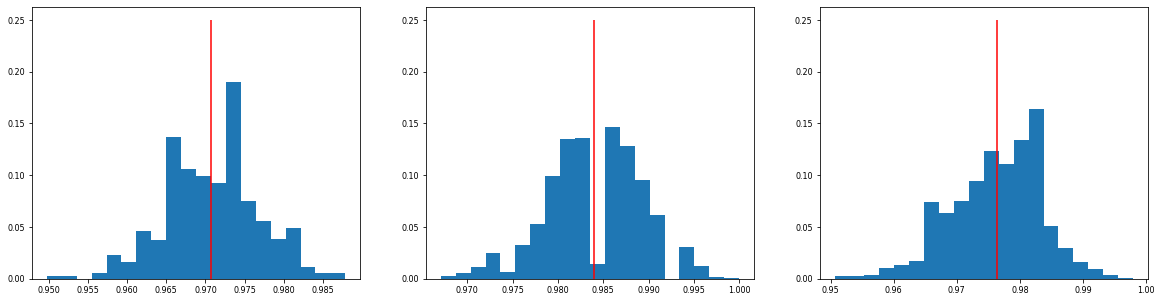

In [60]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize = (20, 5))

axs[0].hist(score, bins = 20, weights=np.ones(iterations)/iterations)
axs[0].vlines(np.mean(score), ymin= 0, ymax = 0.25, color='red')

axs[1].hist(precision, bins = 20, weights=np.ones(iterations)/iterations)
axs[1].vlines(np.mean(precision), ymin= 0, ymax = 0.25, color='red')

axs[2].hist(recall, bins = 20, weights=np.ones(iterations)/iterations)
axs[2].vlines(np.mean(recall), ymin= 0, ymax = 0.25, color='red')

plt.show()

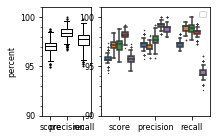

Accuracy mean:  0.9685577379340923
Precision mean:  0.9797885963902805
Recall mean:  0.9757476674918573


In [62]:
data1 = [np.array(score)*100, np.array(precision)*100, np.array(recall)*100]
data2 = [np.array(accu)*100, np.array(prec)*100, np.array(reca)*100]

boxplotprops = {'boxprops':dict(linewidth=1, color='k'), 
    'medianprops':dict(linewidth=1, color='k'), 
    'whiskerprops':dict(linestyle='-', color='k'), 
    'capprops':dict(color='k'),
   'flierprops':dict(markerfacecolor='k', marker='.', linewidth=0.5, markersize = 2)
    }

import matplotlib
colors = matplotlib.cm.get_cmap('tab20c')
import numpy as np

current_class = [96, 97, 96]
fig = plt.figure(figsize=(3,2))

axs0 = plt.subplot2grid((1,3),(0,0))
axs1 = plt.subplot2grid((1,3),(0,1), colspan=2)

axs0.boxplot(data1, widths = 0.65, **boxplotprops)# flierprops=flier)#, boxprops=boxprops, medianprops=medianprops, notch=False, widths=0.75)
axs0.set_ylim([90, 101])
axs0.set_xticklabels(['score', 'precision', 'recall'])
axs0.set_yticks([90, 95, 100])
axs0.set_ylabel('percent')
axs0.minorticks_on()
axs0.tick_params(axis='x', which='minor', bottom=False)

im = sns.boxplot(x='metric', y='value', hue='variable', data=metric_data,
           ax = axs1, fliersize = 0.5)#, palette = grayify_cmap('jet'))

axs1.set_ylim([90, 101])
# ax[1].set_yticks([])
axs1.set_ylabel('')

axs1.minorticks_on()
axs1.set_xticks([0, 1, 2])
axs1.set_xticklabels(['score', 'precision', 'recall'])
plt.legend([])
axs1.set_yticks([90, 95, 100])
axs1.tick_params(axis='x', which='minor', bottom=False)
axs1.set_xlabel('')
for i,box in enumerate(im.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
    box.set_linewidth(1)
    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
        im.lines[j].set_color('black')
        im.lines[j].set_linewidth(1)
if save:
    plt.savefig(save_dir+'Novel_data_comparison_20min_Correction.svg', dpi = 600)
plt.show()


print('Accuracy mean: ', np.mean(accu))
print('Precision mean: ', np.mean(prec))
print('Recall mean: ', np.mean(reca))

In [63]:

print('Classical Accuracy mean: ', np.mean(score), ' +/- ', np.std(score))
print('Classical Precision mean: ', np.mean(precision), ' +/- ', np.std(precision))
print('Classical Recall mean: ', np.mean(recall), ' +/- ', np.std(recall))
    
    
print('\nNovel Accuracy mean: ', np.mean(accu), ' +/- ', np.std(accu))
print('Novel Precision mean: ', np.mean(prec), ' +/- ', np.std(prec))
print('Novel Recall mean: ', np.mean(reca), ' +/- ', np.std(reca))

Classical Accuracy mean:  0.9707123287671234  +/-  0.006006959954828888
Classical Precision mean:  0.9840191676663897  +/-  0.005351126112072196
Classical Recall mean:  0.9762983539094651  +/-  0.007077602796545032

Novel Accuracy mean:  0.9685577379340923  +/-  0.010388956756497626
Novel Precision mean:  0.9797885963902805  +/-  0.010034311208271075
Novel Recall mean:  0.9757476674918573  +/-  0.017873048163178994


# post analysis 


Confident and correct:  0.9241420830824805
Confident and incorrect:  0.008428657435279952
uncertain and correct:  0.04515352197471403
certain and incorrect:  0.022275737507525588


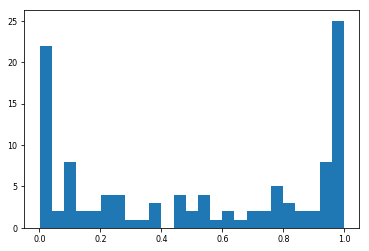

In [34]:
novel_results.loc[novel_results[novel_results['percent']==novel_results['neural']].index ,'alwaysTP_TN']=1

novel_data.loc[novel_data['hemodynamic']==1, 'class'] = 'v'
novel_data.loc[novel_data['movement']==1, 'class'] = 'o'
novel_data.loc[novel_data['artifact']==0, 'class'] = 'n'
novel_results['class'] = novel_data['class']


uc_in = novel_results.loc[novel_results['alwaysTP_TN']!=1].copy()
novel_results.loc[novel_results[novel_results['percent']==novel_results['artifact']].index ,'alwaysFP_FN']=1
uncertain_index = novel_results.loc[np.isnan(novel_results['alwaysTP_TN'])&np.isnan(novel_results['alwaysFP_FN'])].index
novel_results.loc[uncertain_index, 'rounded'] = np.round(novel_results.loc[uncertain_index,'percent'])
novel_results['rounded_all'] = np.round(novel_results['percent'])


uc = novel_results.loc[uncertain_index]
hc = uc.loc[(uc['percent']<=0.25)|(uc['percent']>=0.75), 'percent'].copy()
novel_results.loc[hc.index, 'high_confident'] = 1
lc = uc.loc[(uc['percent']>0.25)&(uc['percent']<0.75), 'percent'].copy()
novel_results.loc[lc.index, 'low_confident'] = 1


# novel_results.loc[novel_results.loc[hc.index, 'percent']==novel_results.loc[hc.index, 'neural'], 'highTP_TN']=1




print('Confident and correct: ' ,np.nansum(novel_results['alwaysTP_TN'])/len(novel_results))
print('Confident and incorrect: ',np.nansum(novel_results['alwaysFP_FN'])/len(novel_results))

print('uncertain and correct: ', len(novel_results.loc[novel_results['rounded']==novel_results['neural']])/len(novel_results))
print('certain and incorrect: ', len(novel_results.loc[novel_results['rounded']==novel_results['artifact']])/len(novel_results))

# print('Less certain and incorrect: ' ,len(hc.loc[(uc['percent']>0.25)&(uc['percent']<0.75), 'percent'])/len(novel_results))

# high_uncertain_index = novel_results.loc[novel_results].index

plt.hist(novel_results.loc[uncertain_index, 'percent'], bins = 25)
plt.show()

190408_07-08
TP/TN: 0.9063545150501672
FP/FN: 0.010033444816053512


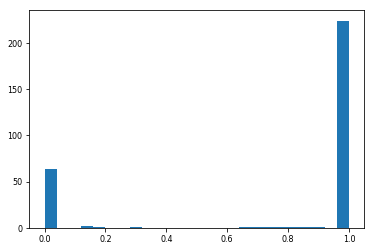

190423_03-04
TP/TN: 0.9333333333333333
FP/FN: 0.012698412698412698


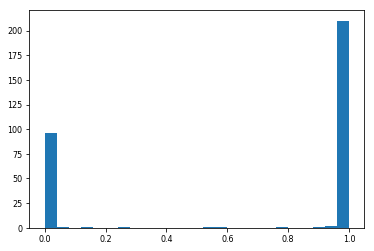

190508_03-04
TP/TN: 0.9156626506024096
FP/FN: 0.0030120481927710845


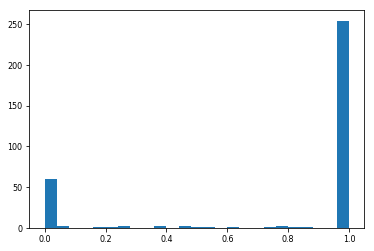

190508_07-08
TP/TN: 0.9354005167958657
FP/FN: 0.00516795865633075


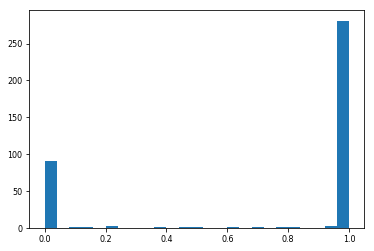

200110_01-02
TP/TN: 0.926829268292683
FP/FN: 0.012195121951219513


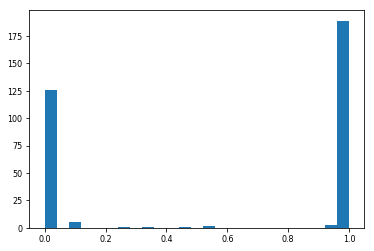

In [35]:
animals = np.unique(novel_results['anml'])

alwaysTPTN = np.zeros(len(animals))
alwaysFPFN = np.zeros(len(animals))


for i, anml in enumerate(animals):
    subset = novel_results[novel_results['anml']==anml].copy()
    print(subset.index[0][:12])
    alwaysTPTN[i] = np.nansum(subset['alwaysTP_TN'])/len(subset)
    alwaysFPFN[i] = np.nansum(subset['alwaysFP_FN'])/len(subset)
    print('TP/TN:', np.nansum(subset['alwaysTP_TN'])/len(subset))
    print('FP/FN:', np.nansum(subset['alwaysFP_FN'])/len(subset))
    plt.hist(subset['percent'], bins = 25)
    # plt.ylim(0,6)
    plt.show()

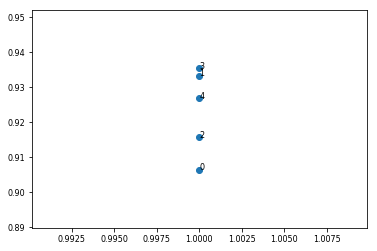

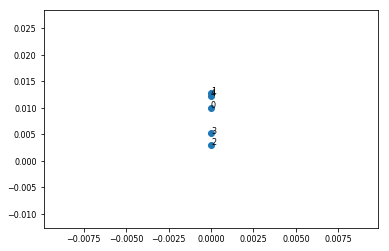

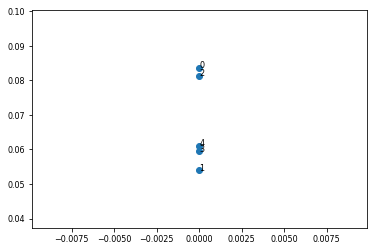

In [36]:
plt.figure()
for i, exp in enumerate(explist):
    plt.text(np.ones(len(animals))[i], alwaysTPTN[i], str(i))
plt.scatter(np.ones(len(animals)), alwaysTPTN)
plt.show()

plt.figure()
for i, exp in enumerate(explist):
    plt.text(np.zeros(len(animals))[i], alwaysFPFN[i], str(i))
plt.scatter(np.zeros(len(animals)), alwaysFPFN)
plt.show()

plt.figure()
for i, exp in enumerate(explist):
    plt.text(np.zeros(len(animals))[i], 1-(alwaysFPFN+alwaysTPTN)[i], str(i))
plt.scatter(np.zeros(len(animals)), 1-(alwaysFPFN+alwaysTPTN))
plt.show()

In [37]:
novel_data.loc[novel_data['hemodynamic']==1, 'class'] = 'v'
novel_data.loc[novel_data['movement']==1, 'class'] = 'o'
novel_data.loc[novel_data['artifact']==0, 'class'] = 'n'


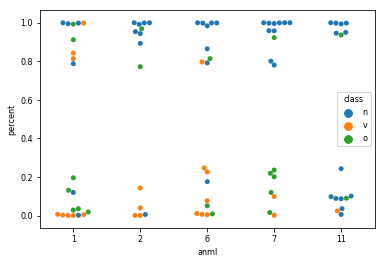

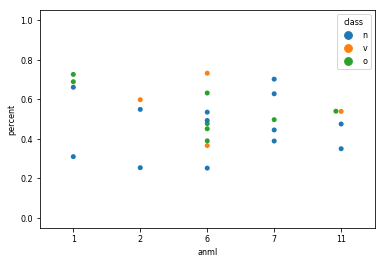

In [38]:
sns.swarmplot(x = novel_data.loc[hc.index, 'anml'], y = novel_results.loc[hc.index, 'percent'],
              hue = novel_data.loc[hc.index, 'class'], hue_order=['n', 'v', 'o'])
plt.show()
sns.swarmplot(x = novel_data.loc[lc.index, 'anml'], y = novel_results.loc[lc.index, 'percent'],
              hue = novel_data.loc[lc.index, 'class'], hue_order=['n', 'v', 'o'])
plt.ylim(-0.05,1.05)
plt.show()

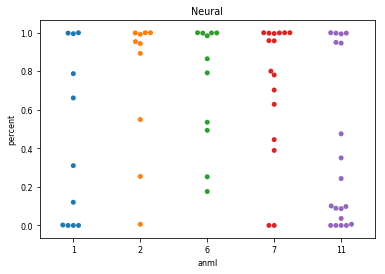

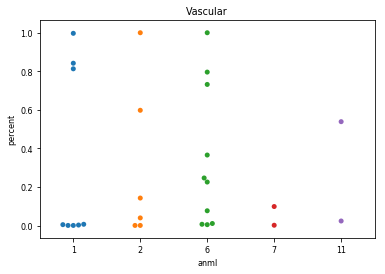

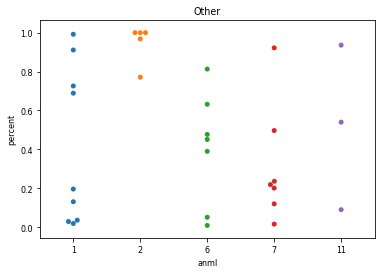

In [39]:
sns.swarmplot(x = uc_in.loc[uc_in['class']=='n', 'anml'], 
              y = uc_in.loc[uc_in['class']=='n', 'percent'],
              #hue = novel_data.loc[hc.index, 'class'], hue_order=['n', 'v', 'o'])
             )
plt.title('Neural')
plt.show()
sns.swarmplot(x = uc_in.loc[uc_in['class']=='v', 'anml'], 
              y = uc_in.loc[uc_in['class']=='v', 'percent'],
              #hue = novel_data.loc[hc.index, 'class'], hue_order=['n', 'v', 'o'])
             )
plt.title('Vascular')
plt.show()
sns.swarmplot(x = uc_in.loc[uc_in['class']=='o', 'anml'], 
              y = uc_in.loc[uc_in['class']=='o', 'percent'],
              #hue = novel_data.loc[hc.index, 'class'], hue_order=['n', 'v', 'o'])
             )
plt.title('Other')
plt.show()

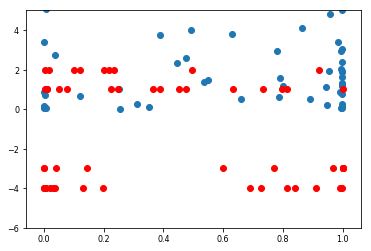

In [40]:
# for i, a in enumerate(np.unique(uc_in['anml'])):
#     uc_in.loc[uc_in['anml']==a,'anml']=i


plt.scatter(x = uc_in.loc[uc_in['class']=='n', 'percent'],
              y = uc_in.loc[uc_in['class']=='n', 'anml']*np.random.random(np.sum(uc_in['class']=='n')),
             )

plt.scatter(x = uc_in.loc[(uc_in['class']=='v')|(uc_in['class']=='o'), 'percent'], 
              y = uc_in.loc[(uc_in['class']=='v')|(uc_in['class']=='o'), 'anml']-5, 
             color = 'red')
plt.ylim(-6,5)

plt.show()

exp_ic
190408_07-08-0016              False
190408_07-08-0097               True
190408_07-08-0099              False
190408_07-08-0169              False
190408_07-08-0271              False
190408_07-08-0298              False
190423_03-04-0103              False
190423_03-04-0295              False
190508_03-04-0265              False
190508_03-04-0268              False
190508_03-04-0290              False
190508_07-08-0041              False
190508_07-08-0317              False
190508_07-08-0326              False
190508_07-08-0374              False
200110_01-02_tmax12000-0079    False
200110_01-02_tmax12000-0091    False
200110_01-02_tmax12000-0115    False
200110_01-02_tmax12000-0144    False
200110_01-02_tmax12000-0154    False
200110_01-02_tmax12000-0165    False
200110_01-02_tmax12000-0172    False
200110_01-02_tmax12000-0178    False
200110_01-02_tmax12000-0189    False
200110_01-02_tmax12000-0206    False
200110_01-02_tmax12000-0216    False
200110_01-02_tmax12000-0254    

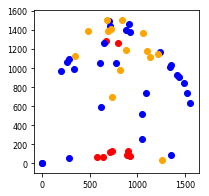

In [41]:
fig, axs = plt.subplots(1,1,figsize=(3,3))


axs.scatter(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='v'), 'region_centroid_1'],
            novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='v'), 'region_centroid_0'],
           c='Red')
axs.scatter(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='n'), 'region_centroid_1'],
            novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='n'), 'region_centroid_0'],
           c='Blue')
axs.scatter(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='o'), 'region_centroid_1'],
            novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='o'), 'region_centroid_0'],
           c='Orange')
axs.set_aspect(1)
print(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='n'), 'region_centroid_1']==0)

plt.show()

In [42]:
animals = np.unique(novel_data['anml'])
n_components = np.zeros((len(animals)))

for i, anml in enumerate(animals):
    animal = novel_data[novel_data['anml']==anml]
#     n_components[i] = int(animal.index[-1][-4:])
    n_components[i] = len(animal)
    for n, j in enumerate(animal.index[::-1]):
        novel_data.loc[j,'var_pos'] = int(j[-3:])
        novel_data.loc[j,'rel_pos'] = int(j[-3:])/n_components[i]

In [43]:
for ind in novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='o'), 'rel_pos'].index:
    print(novel_data.loc[ind, 'rel_pos'])

0.07023411371237458
0.49498327759197325
0.5284280936454849
0.8394648829431438
0.06031746031746032
0.07936507936507936
0.692063492063492
0.8539682539682539
0.9682539682539683
0.8102409638554217
0.8253012048192772
0.04392764857881137
0.0
0.7896341463414634


190408_07-08
Neural /n -------------------------------
Index(['190408_07-08-0016', '190408_07-08-0097', '190408_07-08-0099',
       '190408_07-08-0169', '190408_07-08-0271', '190408_07-08-0298'],
      dtype='object', name='exp_ic')
Other /n -------------------------------
Index(['190408_07-08-0021', '190408_07-08-0148', '190408_07-08-0158',
       '190408_07-08-0251'],
      dtype='object', name='exp_ic')
Vascular /n -------------------------------
Index(['190408_07-08-0003', '190408_07-08-0007', '190408_07-08-0175'], dtype='object', name='exp_ic')


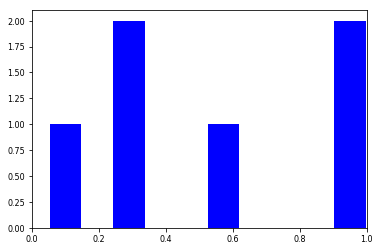

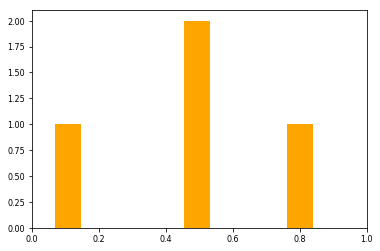

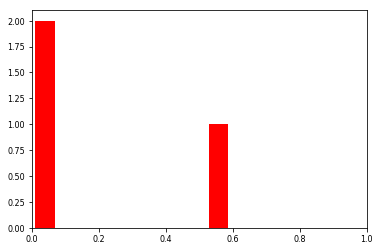

190423_03-04
Neural /n -------------------------------
Index(['190423_03-04-0103', '190423_03-04-0295'], dtype='object', name='exp_ic')
Other /n -------------------------------
Index(['190423_03-04-0019', '190423_03-04-0025', '190423_03-04-0218',
       '190423_03-04-0269', '190423_03-04-0305'],
      dtype='object', name='exp_ic')
Vascular /n -------------------------------
Index(['190423_03-04-0009', '190423_03-04-0070'], dtype='object', name='exp_ic')


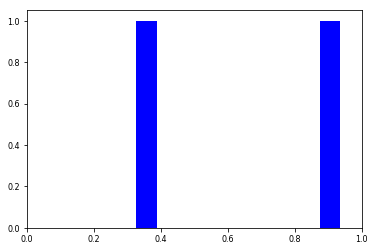

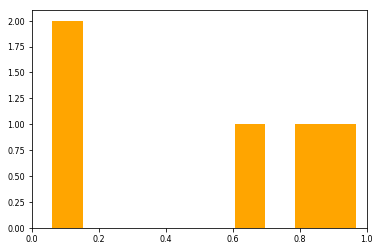

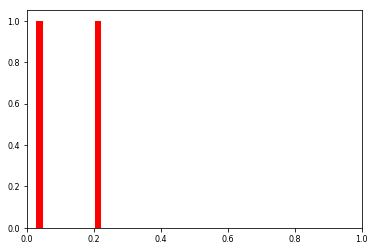

190508_03-04
Neural /n -------------------------------
Index(['190508_03-04-0265', '190508_03-04-0268', '190508_03-04-0290'], dtype='object', name='exp_ic')
Other /n -------------------------------
Index(['190508_03-04-0269', '190508_03-04-0274'], dtype='object', name='exp_ic')
Vascular /n -------------------------------
Index(['190508_03-04-0026', '190508_03-04-0061', '190508_03-04-0122'], dtype='object', name='exp_ic')


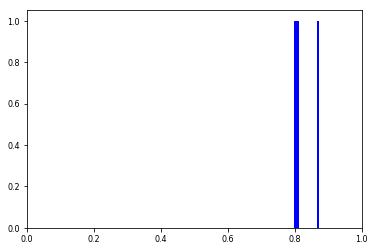

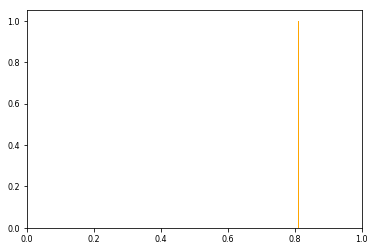

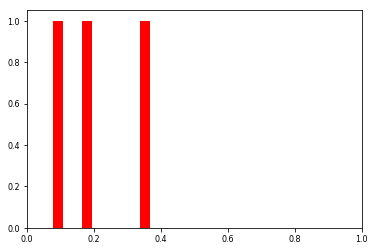

190508_07-08
Neural /n -------------------------------
Index(['190508_07-08-0041', '190508_07-08-0317', '190508_07-08-0326',
       '190508_07-08-0374'],
      dtype='object', name='exp_ic')
Other /n -------------------------------
Index(['190508_07-08-0017'], dtype='object', name='exp_ic')
Vascular /n -------------------------------
Index([], dtype='object', name='exp_ic')


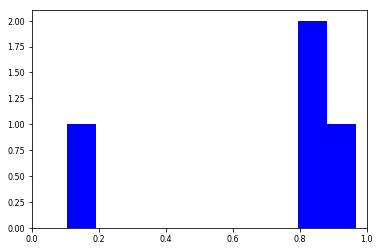

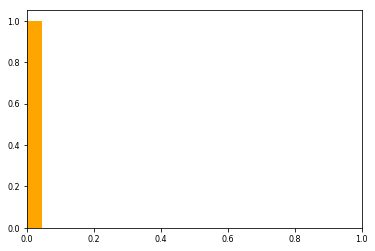

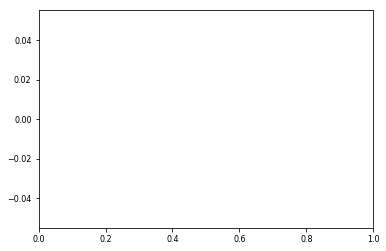

200110_01-02
Neural /n -------------------------------
Index(['200110_01-02_tmax12000-0079', '200110_01-02_tmax12000-0091',
       '200110_01-02_tmax12000-0115', '200110_01-02_tmax12000-0144',
       '200110_01-02_tmax12000-0154', '200110_01-02_tmax12000-0165',
       '200110_01-02_tmax12000-0172', '200110_01-02_tmax12000-0178',
       '200110_01-02_tmax12000-0189', '200110_01-02_tmax12000-0206',
       '200110_01-02_tmax12000-0216', '200110_01-02_tmax12000-0254',
       '200110_01-02_tmax12000-0256'],
      dtype='object', name='exp_ic')
Other /n -------------------------------
Index(['200110_01-02_tmax12000-0000', '200110_01-02_tmax12000-0259'], dtype='object', name='exp_ic')
Vascular /n -------------------------------
Index(['200110_01-02_tmax12000-0041'], dtype='object', name='exp_ic')


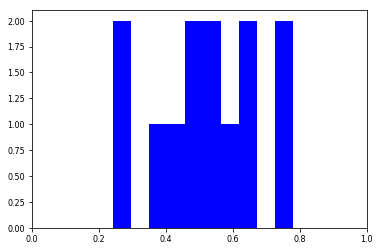

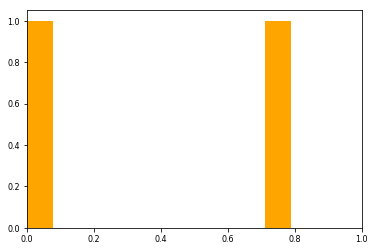

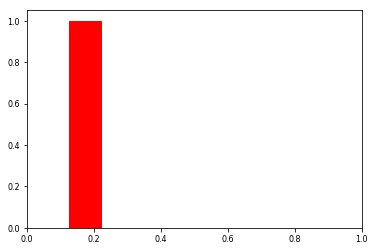

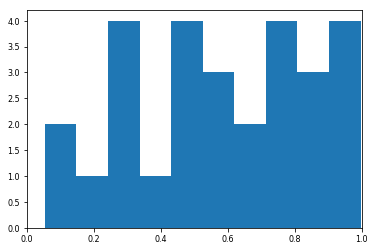

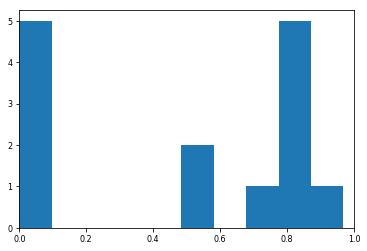

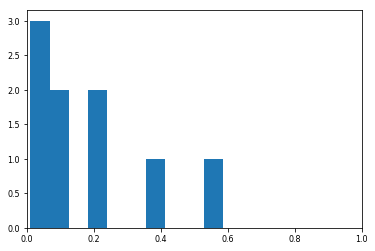

In [44]:

for a in animals:
    subset = novel_data[novel_data['anml']==a].copy()
    result = novel_results[novel_results['anml']==a].copy()
    print(subset.index[0][:12])
    print('Neural /n -------------------------------')
    print(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='n')].index)
    print('Other /n -------------------------------')
    print(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='o')].index)
    print('Vascular /n -------------------------------')
    print(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='v')].index)
    plt.hist(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='n'), 'rel_pos'], color='blue')
    plt.xlim(0,1)
    plt.show()
    plt.hist(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='o'), 'rel_pos'], color='orange')
    plt.xlim(0,1)
    plt.show()
    plt.hist(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='v'), 'rel_pos'], color = 'red')
    plt.xlim(0,1)
    plt.show()
    
    
    
    
plt.hist(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='n'), 'rel_pos'])
plt.xlim(0,1)
plt.show()
plt.hist(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='o'), 'rel_pos'])
plt.xlim(0,1)
plt.show()
plt.hist(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='v'), 'rel_pos'])
plt.xlim(0,1)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


190408_07-08
190423_03-04
190508_03-04
190508_07-08
200110_01-02


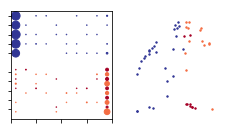

In [45]:


novel_data['region_centroid_1_ud'] = (novel_data['region_centroid_1']-np.max(novel_data['region_centroid_1'])/2)*6.75/1000
novel_data['region_centroid_0_ud'] = novel_data['region_centroid_0']*6.75/1000

fig, axs = plt.subplots(1,2,figsize=(4,2))


for i, a in enumerate(animals):
    subset = novel_data[novel_data['anml']==a].copy()
    result = novel_results[novel_results['anml']==a].copy()
    print(subset.index[0][:12])
    if i ==0:
        binn = 10
        P = np.histogram(result.loc[subset['class']=='n', 'percent'],binn)
        bins = P[1]
        binpos = P[1][:-1]+(P[1][1:]-P[1][:-1])/2
        per_val = np.zeros((len(animals),3,binn))

    else:
        P = np.histogram(result.loc[subset['class']=='n', 'percent'],bins)
    axs[0].scatter(binpos, np.ones(len(P[0]))*-i*2, s = P[0]/len(subset)*100, color=plt.cm.get_cmap('RdYlBu',6)(5))
    per_val[i,0] = P[0]
    N = np.histogram(result.loc[(subset['class']=='v'), 'percent'],bins=bins)
    axs[0].scatter(binpos, np.ones(len(N[0]))*-1*i*2-11.5, s = N[0]/len(subset)*100, color=plt.cm.get_cmap('RdYlBu',6)(0))
    per_val[i,1] = N[0]
    N = np.histogram(result.loc[subset['class']=='o', 'percent'],bins=P[1])
    axs[0].scatter(binpos, np.ones(len(N[0]))*-1*i*2-12.5, s = N[0]/len(subset)*100, color= plt.cm.get_cmap('RdYlBu',6)(1))
    per_val[i,2] = N[0]
axs[0].set_xlim(1,0)
axs[0].set_yticks([0,-2,-4,-6,-8,-12,-14,-16,-18,-20])
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])


axs[1].scatter(np.abs(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='n'), 'region_centroid_1_ud']),
            novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='n'), 'region_centroid_0_ud'],
           c=plt.cm.get_cmap('RdYlBu',6)(5), s=2)

axs[1].scatter(-1*np.abs(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='v'), 'region_centroid_1_ud']),
            novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='v'), 'region_centroid_0_ud'],
           c=plt.cm.get_cmap('RdYlBu',6)(0), s=2)
axs[1].scatter(-1*np.abs(novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='o'), 'region_centroid_1_ud']),
            novel_data.loc[(novel_results['rounded_all']!=novel_results['neural'])&(novel_data['class']=='o'), 'region_centroid_0_ud'],
           c=plt.cm.get_cmap('RdYlBu',6)(1), s=2)

axs[1].set_xlim(novel_data['region_centroid_1_ud'].max()+0.5,novel_data['region_centroid_1_ud'].min()-0.5)
axs[1].set_ylim(novel_data['region_centroid_0_ud'].min()-0.5, novel_data['region_centroid_0_ud'].max()+0.5)
axs[1].set_aspect(1)
axs[1].axis('off')
plt.savefig('Novel_data_comparison_confusion_mat_loc_OB.svg', dpi = 600)
plt.show()

# plt.hist(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='o'), 'rel_pos'], color='orange')
# plt.xlim(0,1)
# plt.show()
# plt.hist(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='v'), 'rel_pos'], color = 'red')
# plt.xlim(0,1)
# plt.show()

190408_07-08
190423_03-04
190508_03-04
190508_07-08
200110_01-02


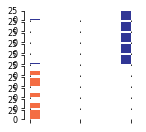

In [46]:


novel_data['region_centroid_1_ud'] = (novel_data['region_centroid_1']-np.max(novel_data['region_centroid_1'])/2)*6.75/1000
novel_data['region_centroid_0_ud'] = novel_data['region_centroid_0']*6.75/1000

fig, axs = plt.subplots(10,1,figsize=(2,2))


for i, a in enumerate(animals):
    subset = novel_data[novel_data['anml']==a].copy()
    result = novel_results[novel_results['anml']==a].copy()
    print(subset.index[0][:12])
    if i ==0:
        binn = 10
        P = np.histogram(result.loc[subset['class']=='n', 'percent'],binn)
        bins = P[1]
        binpos = P[1][:-1]+(P[1][1:]-P[1][:-1])/2
        per_val = np.zeros((len(animals),3,binn))

    else:
        P = np.histogram(result.loc[subset['class']=='n', 'percent'],bins)
    axs[i].bar(binpos, P[0]/len(subset)*100, width = 0.1,
               color=plt.cm.get_cmap('RdYlBu',6)(5))
    per_val[i,0] = P[0]
    N = np.histogram(result.loc[(subset['class']=='v'), 'percent'],bins=bins)
    axs[i+5].bar(binpos, N[0]/len(subset)*100, width = 0.1,
                 color=plt.cm.get_cmap('RdYlBu',6)(0))
    per_val[i,1] = N[0]
    N = np.histogram(result.loc[subset['class']=='o', 'percent'],bins=P[1])
    axs[i+5].bar(binpos, N[0]/len(subset)*100, width = 0.1,
                 color= plt.cm.get_cmap('RdYlBu',6)(1))
    per_val[i,2] = N[0]
    axs[i].set_xticklabels([])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].set_ylim(0,25)
    axs[i+5].set_xticklabels([])
    axs[i+5].spines['right'].set_visible(False)
    axs[i+5].spines['top'].set_visible(False)
    axs[i+5].spines['bottom'].set_visible(False)
    axs[i+5].set_ylim(0,25)

    
# axs[0].set_xlim(1,0)
# axs[0].set_yticks([0,-2,-4,-6,-8,-12,-14,-16,-18,-20])
# axs[0].set_yticklabels([])
# axs[0].set_xticklabels([])

plt.savefig('Novel_data_comparison_confusion_mat_hist.svg', dpi = 600)
plt.show()

# plt.hist(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='o'), 'rel_pos'], color='orange')
# plt.xlim(0,1)
# plt.show()
# plt.hist(subset.loc[(result['rounded_all']!=result['neural'])&(subset['class']=='v'), 'rel_pos'], color = 'red')
# plt.xlim(0,1)
# plt.show()

In [47]:
np.sum(per_val[:,0,:], axis = 0)/np.sum(per_val)

array([0.00963275, 0.00180614, 0.00180614, 0.00180614, 0.00180614,
       0.00120409, 0.00120409, 0.00240819, 0.00180614, 0.69596629])

In [8]:
fig, axs = plt.subplots(1,1,figsize=(2,0.5))

axs.scatter(binpos, np.ones(4)*0, s = np.sum(per_val[:,0,:], axis = 0)/np.sum(per_val)*100, 
            edgecolor="none",
            color=plt.cm.get_cmap('RdYlBu',6)(5))
axs.scatter(binpos, np.ones(4)*-.5, s = np.sum(per_val[:,1,:], axis = 0)/np.sum(per_val)*100, 
            edgecolor="none",
            color=plt.cm.get_cmap('RdYlBu',6)(0))
axs.scatter(binpos, np.ones(4)*-.75, s =  np.sum(per_val[:,2,:], axis = 0)/np.sum(per_val)*100,
            edgecolor="none",
            color=plt.cm.get_cmap('RdYlBu',6)(1))
axs.set_xlim(1,0)
axs.set_ylim(-1,0.5)

axs.set_yticklabels([])
axs.set_xticklabels([])
fig.savefig('novel_performance_mat.svg', dpi=600)
plt.show()

NameError: name 'binpos' is not defined

In [ ]:
plt.rcParams['font.size'] = 8
fig, axs = plt.subplots(2,1,figsize=(2,0.75))

print(np.max(np.sum(per_val[:,0,:], axis = 0)/np.sum(per_val)*100))
print(np.std(per_val[:,0,:]/np.sum(per_val)*100, axis = 0)[-1])

# axs[0].bar(binpos, np.sum(per_val[:,0,:], axis = 0)/np.sum(per_val)*100, width = 0.1,
#            yerr =  np.std(per_val[:,0,:]/np.sum(per_val)*100, axis = 0),
#            color=plt.cm.get_cmap('RdYlBu',6)(5))
axs[0].bar(binpos, np.sum(per_val[:,0,:], axis = 0)/np.sum(per_val)*100, width = 0.1,
           yerr =  np.std(per_val[:,0,:]/np.sum(per_val)*100, axis = 0),
           color=plt.cm.get_cmap('RdYlBu',6)(5))
axs[1].bar(binpos, np.sum(per_val[:,1,:], axis = 0)/np.sum(per_val)*100, width = 0.1,
           yerr =  np.std(per_val[:,1,:]/np.sum(per_val)*100, axis = 0),
           color=plt.cm.get_cmap('RdYlBu',6)(0))
bottoms = np.sum(per_val[:,1,:], axis = 0)/np.sum(per_val)*100
axs[1].bar(binpos, np.sum(per_val[:,2,:], axis = 0)/np.sum(per_val)*100, width = 0.1, 
           yerr =  np.std(per_val[:,2,:]/np.sum(per_val)*100, axis = 0),
           bottom=bottoms,
        color=plt.cm.get_cmap('RdYlBu',6)(1))

print('highest neuro classified: ', np.sum(per_val[:,0,9], axis = 0)/np.sum(per_val)*100, ' +/- ', 
           np.std(per_val[:,0,9], axis = 0)/np.sum(per_val)*100)
print('highest artifact classified: ', np.sum(per_val[:,1,0] + per_val[:,2,0], axis = 0)/np.sum(per_val)*100, ' +/- ', 
           np.std(per_val[:,1,0] + per_val[:,2,0], axis = 0)/np.sum(per_val)*100)
print('highest vascular classified: ', np.sum(per_val[:,1,0], axis = 0)/np.sum(per_val)*100, ' +/- ', 
           np.std(per_val[:,1,0], axis = 0)/np.sum(per_val)*100)
print('highest other classified: ', np.sum(per_val[:,2,0], axis = 0)/np.sum(per_val)*100, ' +/- ', 
           np.std(per_val[:,2,0], axis = 0)/np.sum(per_val)*100)

# axs[0].set_xticklabels([])
# axs[0].spines['right'].set_visible(False)
# axs[0].spines['top'].set_visible(False)
# axs[0].spines['bottom'].set_visible(False)
# axs[0].set_ylim(50,80)
# axs[0].set_xticks([])
# axs[0].set_xlim([1,0])

axs[0].set_xticklabels([])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
# axs[1].spines['bottom'].set_visible(False)
axs[0].set_ylim(0.1,100)
axs[0].set_xlim([1,0])
axs[0].set_yscale('log')

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
# axs[2].spines['bottom'].set_visible(False)
axs[1].set_ylim(.1,100)
axs[1].set_xlim([1,0])
axs[1].set_yscale('log')

fig.savefig('classifier_performance_mat_novel_hist.svg', dpi=600)
plt.show()


fig.savefig('classifier_performance_mat_novel_hist_STD.svg', dpi=600)
plt.show()

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(2,0.5))

axs.scatter(binpos, np.ones(4)*0, s = [5,25,50,100], 
            edgecolor="none",
            color='k')
axs.scatter(binpos[1], -.5, s = 25, 
            edgecolor="none",
            color=plt.cm.get_cmap('RdYlBu',6)(5))
axs.scatter(binpos[2], -.5, s = 25, 
            edgecolor="none",
            color=plt.cm.get_cmap('RdYlBu',6)(0))
axs.scatter(binpos[3], -.5, s =  25,
            edgecolor="none",
            color=plt.cm.get_cmap('RdYlBu',6)(1))

axs.set_xlim(1,0)
axs.set_ylim(-1,0.5)

axs.set_yticklabels([])
axs.set_xticklabels([])
fig.savefig('scales.svg', dpi=600)
plt.show()